<a href="https://colab.research.google.com/github/JencyCS/DataScience/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

K means Clustering

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Finance_data.csv to Finance_data.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [3]:
# Load the dataset
data = pd.read_csv('Finance_data.csv')
data.head()

,gender,age,Investment_Avenues,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold,...,Duration,Invest_Monitor,Expect,Avenue,What are your savings objectives?,Reason_Equity,Reason_Mutual,Reason_Bonds,Reason_FD,Source
0,Female,34,Yes,1,2,5,3,7,6,4,...,1-3 years,Monthly,20%-30%,Mutual Fund,Retirement Plan,Capital Appreciation,Better Returns,Safe Investment,Fixed Returns,Newspapers and Magazines
1,Female,23,Yes,4,3,2,1,5,6,7,...,More than 5 years,Weekly,20%-30%,Mutual Fund,Health Care,Dividend,Better Returns,Safe Investment,High Interest Rates,Financial Consultants
2,Male,30,Yes,3,6,4,2,5,1,7,...,3-5 years,Daily,20%-30%,Equity,Retirement Plan,Capital Appreciation,Tax Benefits,Assured Returns,Fixed Returns,Television
3,Male,22,Yes,2,1,3,7,6,4,5,...,Less than 1 year,Daily,10%-20%,Equity,Retirement Plan,Dividend,Fund Diversification,Tax Incentives,High Interest Rates,Internet
4,Female,24,No,2,1,3,6,4,5,7,...,Less than 1 year,Daily,20%-30%,Equity,Retirement Plan,Capital Appreciation,Better Returns,Safe Investment,Risk Free,Internet


In [13]:
# Identify numerical and categorical features
numerical_features = ['Mutual_Funds', 'Equity_Market', 'Debentures',
                      'Government_Bonds', 'Fixed_Deposits', 'PPF',
                      'Gold', 'Stock_Marktet']
categorical_features = ['gender', 'Investment_Avenues', 'Invest_Monitor',
                        'Avenue', 'What are your savings objectives?',
                        'Reason_Equity', 'Reason_Mutual', 'Reason_Bonds',
                        'Reason_FD', 'Source']


In [14]:
# Create a preprocessor that scales numerical features and encodes categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


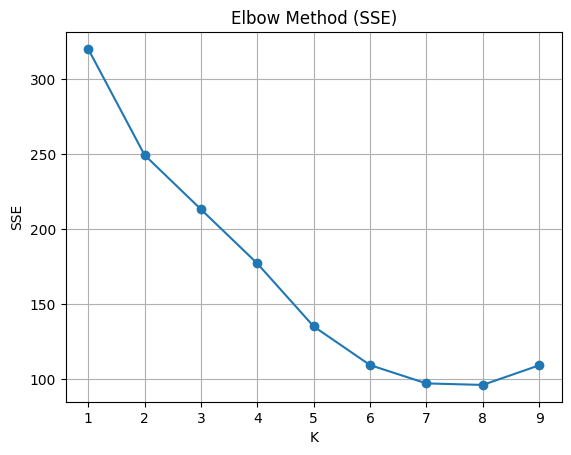

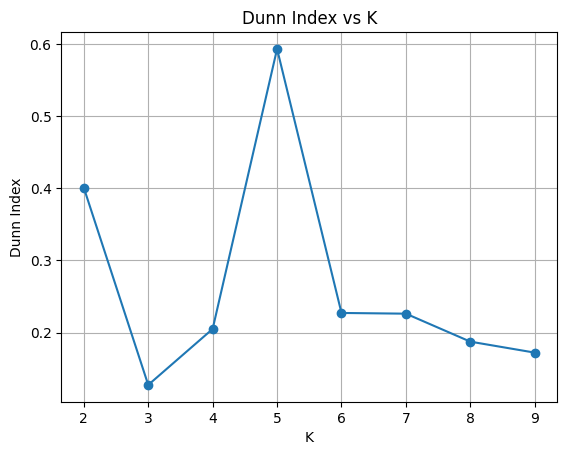

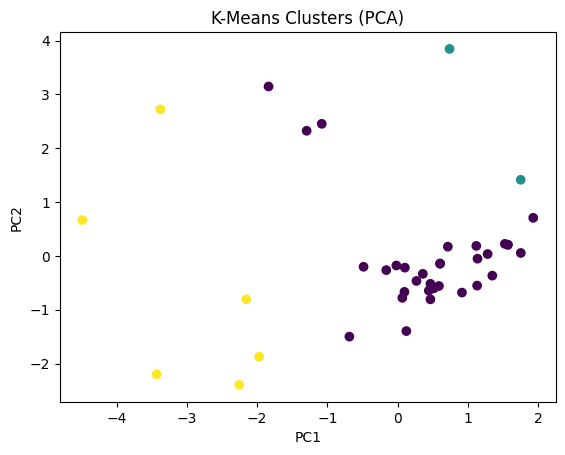

Our SSE: 204.85067556155911
Sklearn SSE: 215.80572301485438
Our Dunn: 0.48122779541581956
Sklearn Dunn: 0.133552340713839


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as SKKMeans


# -----------------------------------------------
# Load Dataset
# -----------------------------------------------
df = pd.read_csv("Finance_data.csv")

# only numeric columns
X_raw = df.select_dtypes(include=[np.number]).dropna()

# scale
scaler = StandardScaler()
X = scaler.fit_transform(X_raw.values)

# Euclidean Distance (Explicit Formula)
def euclidean(a, b):
    # sqrt( sum( (ai - bi)^2 ) )
    return np.sqrt(np.sum((a - b) ** 2))


# Assign clusters using explicit Euclidean distances
def assign_clusters(X, centers):
    labels = []
    for x in X:
        dists = [euclidean(x, c) for c in centers]
        labels.append(np.argmin(dists))
    return np.array(labels)

# KMeans++ Initialization
def initialize_kmeans_pp(X, k):
    centers = []
    n = X.shape[0]

    # first center
    idx = np.random.randint(0, n)
    centers.append(X[idx])

    # remaining centers
    for _ in range(k - 1):
        d2 = []
        for x in X:
            dist = min(euclidean(x, c) ** 2 for c in centers)
            d2.append(dist)
        d2 = np.array(d2)

        probs = d2 / d2.sum()
        idx = np.random.choice(n, p=probs)
        centers.append(X[idx])

    return np.array(centers)


# Update Centroids
def update_centers(X, labels, k):
    centers = []
    for i in range(k):
        pts = X[labels == i]
        if len(pts) == 0:
            centers.append(X[np.random.randint(0, len(X))])
        else:
            centers.append(np.mean(pts, axis=0))
    return np.array(centers)


# SSE using explicit Euclidean formula
def compute_sse(X, centers, labels):
    sse = 0
    for i, c in enumerate(centers):
        pts = X[labels == i]
        for p in pts:
            sse += euclidean(p, c) ** 2
    return sse


# KMeans Algorithm (EM)
def kmeans(X, k, max_iter=300):
    centers = initialize_kmeans_pp(X, k)

    for _ in range(max_iter):
        # E-step
        labels = assign_clusters(X, centers)

        # M-step
        new_centers = update_centers(X, labels, k)

        if np.allclose(new_centers, centers):
            break
        centers = new_centers

    sse = compute_sse(X, centers, labels)
    return centers, labels, sse

# Dunn Index
def dunn_index(X, labels):
    clusters = [X[labels == i] for i in np.unique(labels)]

    # intra-cluster max diameter
    max_diameter = 0
    for c in clusters:
        if len(c) > 1:
            dmax = 0
            for i in range(len(c)):
                for j in range(i + 1, len(c)):
                    d = euclidean(c[i], c[j])
                    if d > dmax:
                        dmax = d
            if dmax > max_diameter:
                max_diameter = dmax

    # inter-cluster minimum distance
    min_inter = np.inf
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            for p in clusters[i]:
                for q in clusters[j]:
                    d = euclidean(p, q)
                    if d < min_inter:
                        min_inter = d

    return min_inter / max_diameter


# Elbow Method (SSE vs K)
SSE = []
DUNN = []
K_RANGE = range(1, 10)

for k in K_RANGE:
    centers, labels, sse = kmeans(X, k)
    SSE.append(sse)
    DUNN.append(dunn_index(X, labels))

# Elbow Plot
plt.plot(K_RANGE, SSE, marker='o')
plt.title("Elbow Method (SSE)")
plt.xlabel("K")
plt.ylabel("SSE")
plt.grid()
plt.show()

# Dunn Plot
plt.plot(K_RANGE, DUNN, marker='o')
plt.title("Dunn Index vs K")
plt.xlabel("K")
plt.ylabel("Dunn Index")
plt.grid()
plt.show()

# Visualization for K=3
k = 3
centers, labels, _ = kmeans(X, k)
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

plt.scatter(X2[:, 0], X2[:, 1], c=labels)
plt.title("K-Means Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Compare With sklearn KMeans++
sk = SKKMeans(n_clusters=k, init="k-means++")
sk.fit(X)
print("Our SSE:", compute_sse(X, centers, labels))
print("Sklearn SSE:", sk.inertia_)
print("Our Dunn:", dunn_index(X, labels))
print("Sklearn Dunn:", dunn_index(X, sk.labels_))
